In [1]:
import pandas as pd
import matplotlib
import os

# Let's define some useful lists first

unknownResult = ["nan0n", "NaN", "NA", "inf"]
crashes = ["Accident", "Collision", "Fatal accident", "Collision damage", "Spun off"]
Europe = ["Austrian", "Belgian", "British", "Czech", "Danish", "Dutch", "East German", "Finnish", "French", "German", "Hungarian", "Irish", "Italian", "Liechtensteiner", "Monegasque", "Polish", "Portuguese", "Russian", "Spanish", "Swedish", "Swiss"]
NAmerica = ["American", "Canadian", "Mexican"]
SAmerica = ["Argentine", "Brazilian", "Chilean", "Colombian", "Uruguayan", "Venezuelan"]
Asia = ["Chinese", "Indian", "Indonesian", "Japanese", "Malaysian", "Thai", "Hong Kong"]
Africa = ["Rhodesian", "South African"]
Oceania = ["Australian", "New Zealander"]
multiple = ["American-Italian", "Argentine-Italian"]

# Now let's load the stats. Source: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020

drivers = pd.read_csv(os.path.join("data", "drivers.csv"))
results = pd.read_csv(os.path.join("data", "results.csv"))
races = pd.read_csv(os.path.join("data", "races.csv"))
circuits = pd.read_csv(os.path.join("data", "circuits.csv"))
status = pd.read_csv(os.path.join("data", "status.csv"))
constructors = pd.read_csv(os.path.join("data", "constructors.csv"))

# Merge all the tables into a single dataframe

results = results.merge(drivers, on="driverId", how="right")
races = races.merge(circuits, on="circuitId", how="right")
results = results.merge(races, on="raceId", how="right")
results = results.merge(status, on="statusId", how="right")
results = results.merge(constructors, on="constructorId", how="right")

# Make the columns more useful 

results["fullname"] = results["forename"] + " " + results["surname"]
results["date"] = results["date"].str.slice(0,6) + results["year"].astype(str).str.slice(0,4)
results["date"] = pd.to_datetime(results["date"], format="%d/%m/%Y")
results["year"] = results["year"].astype(float)
results["round"] = results["round"].astype(float)
results["position"] = results["position"].apply(pd.to_numeric, errors = "coerce").astype(int, errors="ignore")

# Make some new columns

results["year_round"] = results["year"].astype(str).str.slice(0,4) + results["round"].astype(str).str.slice(0,-2).str.zfill(2)
results = results[~results.year_round.isin(unknownResult)]
results["year_round"] = results["year_round"].apply(pd.to_numeric, errors = "coerce").astype(int)

results.loc[results.nationality_x.isin(Europe),"driverContinent"]="Europe"
results.loc[results.nationality_x.isin(NAmerica),"driverContinent"]="NAmerica"
results.loc[results.nationality_x.isin(SAmerica),"driverContinent"]="SAmerica"
results.loc[results.nationality_x.isin(Asia),"driverContinent"]="Asia"
results.loc[results.nationality_x.isin(Africa),"driverContinent"]="Africa"
results.loc[results.nationality_x.isin(Oceania),"driverContinent"]="Oceania"
results.loc[results.nationality_x.isin(multiple),"driverContinent"]="multiple"

entries = pd.Series(results.groupby(["driverId"]).size(), name="entries")
results = results.merge(entries, on = ["driverId"], how = "right")

# Split the main dataframe for wins, podiums and top 6 finishes only 

wins = results[results["position"] == 1]
podiums = results[results["position"] < 4]
top6 = results[results["position"] < 7]

C:\Users\micha\AppData\Local\Temp\ipykernel_22576\4101919612.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'url_x'} in the result is deprecated and will raise a MergeError in a future version.
  results = results.merge(constructors, on="constructorId", how="right")


## Drivers with the most race-ending crashes and the highest race-ending crash ratios 

In [2]:
crashDNF = results[(results.status.isin(crashes))]

In [3]:
driversMostCrashes = crashDNF.groupby("fullname").size()

In [4]:
driversMostCrashes.nlargest(10)

fullname
Andrea de Cesaris       37
Riccardo Patrese        36
David Coulthard         32
Rubens Barrichello      32
Giancarlo Fisichella    30
Jean Alesi              30
Johnny Herbert          30
Michael Schumacher      30
Ukyo Katayama           30
Jarno Trulli            29
dtype: int64

In [5]:
carnageExperts = results[(results.status.isin(crashes)) & (results.entries >= 10)].groupby(["surname", "forename"]).size() / results.groupby(["surname", "forename"]).size()

In [6]:
carnageExperts.nlargest(10)

surname    forename
Andretti   Michael     0.461538
Brise      Tony        0.400000
Inoue      Taki        0.333333
Tuero      Esteban     0.312500
Katayama   Ukyo        0.309278
Chiesa     Andrea      0.300000
Lavaggi    Giovanni    0.300000
Scheckter  Ian         0.300000
Blundell   Mark        0.285714
Pantano    Giorgio     0.285714
dtype: float64

## The most challenging circuits in the last 20 years

In [7]:
results20years = results[results["year"] > 2001]

circuits20yearsResults = results20years.groupby(["location"]).size()

In [8]:
crashDNF20years = crashDNF[crashDNF["year"] > 2001]

circuitsDNF20years = crashDNF20years.groupby(["location"]).size()

In [9]:
circuits20yearsGPs = results20years.groupby(["location"])["year_round"].nunique()

In [10]:
mergedCircuitStats = pd.concat([circuits20yearsGPs, circuits20yearsResults, circuitsDNF20years], axis=1, keys=["circuits20yearsGPs", "circuits20yearsResults", "circuitsDNF20years"])

In [11]:
mergedCircuitStats["ratio"] = mergedCircuitStats["circuitsDNF20years"] / mergedCircuitStats["circuits20yearsResults"]

In [12]:
mergedCircuitStats["ratio"].sort_values(ascending=False).head(5)

location
Mugello           0.300000
Indianapolis      0.185484
Jeddah            0.175000
Yeongam County    0.159574
Monte-Carlo       0.151741
Name: ratio, dtype: float64

In [13]:
frequentCircuitStats = mergedCircuitStats[mergedCircuitStats["circuits20yearsGPs"] > 9]

In [14]:
frequentCircuitStats["ratio"].sort_values(ascending=False)

location
Monte-Carlo     0.151741
Melbourne       0.136139
Marina Bay      0.112403
São Paulo       0.110000
Spa             0.107895
Montreal        0.101648
Nürburg         0.094340
Silverstone     0.090293
Montmeló        0.089623
Hockenheim      0.078431
Suzuka          0.070588
Kuala Lumpur    0.066474
Shanghai        0.064327
Monza           0.054502
Budapest        0.054502
Spielberg       0.052846
Abu Dhabi       0.043478
Sakhir          0.035000
Name: ratio, dtype: float64

## On what lap do the crashes occur?

Todo: calculate a race progress percentage and work with it rather than with a lap count.

In [15]:
crashDNF20years = crashDNF[crashDNF["year"] > 2001]

In [16]:
whatLap = crashDNF20years[["laps"]]

In [17]:
howManyBins = crashDNF20years[["laps"]].max()

array([[<AxesSubplot:title={'center':'laps'}>]], dtype=object)

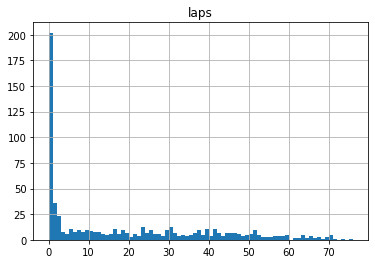

In [18]:
whatLap.hist(bins = 76)